Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [28]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import imutils

import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback




Internal Libraries:

In [2]:
# Internal libraries:
from Helpers.load_images import load_images

from Helpers.preprocessing import multiple_dataset_conversion
from Helpers.preprocessing import crop_images
from Helpers.preprocessing import preprocess_images
from Helpers.preprocessing import augment_image_set
from Helpers.preprocessing import labels_to_categorical

from Helpers.plotting import plot_image_classes
from Helpers.plotting import plot_history
from Helpers.plotting import plot_image
from Helpers.plotting import plot_augmented
from Helpers.confusion_matrix import plot_confusion_matrix

from Helpers.evaluate import evalute_model


from Models.CNN import build_cnn 
from Models.CNN import train_cnn 

from Models.VGG16 import build_vgg16 
from Models.VGG16 import train_vgg16

from Models.RESNET import build_resnet
from Models.RESNET import train_resnet



Load images from the dataset

In [3]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

/Users/arshlalani/Desktop/Current Courses/AI 2/Advanced-AI-Thesis/Helpers/plotting.py:63: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("Image Labels")


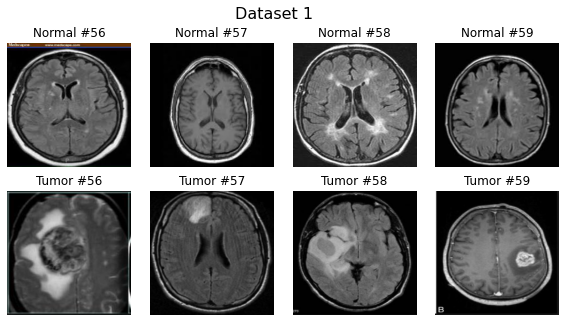

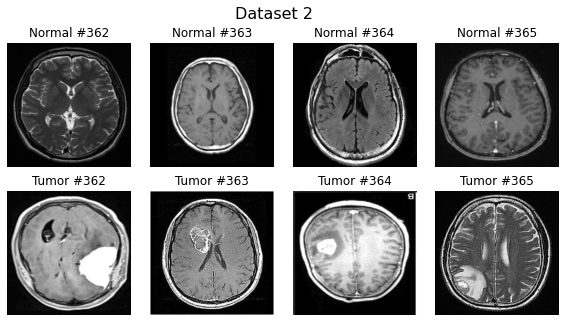

In [4]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

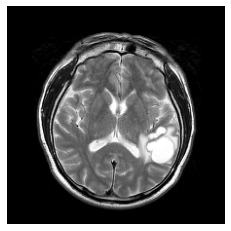

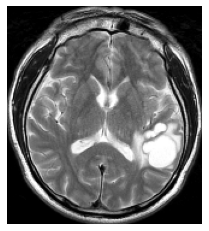

In [5]:
plot_image(dataset_1_tumor_images[4], save="uncropped_test")
dataset_1_tumor_images_proc = crop_images(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_images(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_images(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_images(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image, save="cropped_test")

In [6]:
dataset_1_normal_images_proc = preprocess_images(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_images(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_images(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_images(dataset_2_tumor_images_proc, (224, 224))

Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [7]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

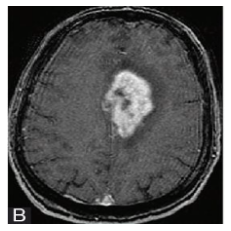

In [8]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0], save="X_light_train")

Preform some data augmentation on the training data

In [9]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


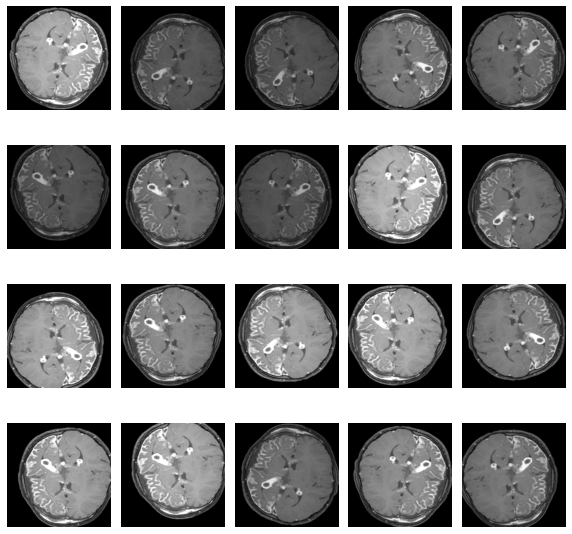

In [10]:
plot_augmented(X_light_train[5], example_datagen)

In [11]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)




        

In [12]:
X_train = np.array(X_train)
Y_train = labels_to_categorical(np.array(Y_train))

X_test = np.array(X_test)
Y_test = labels_to_categorical(np.array(Y_test))

X_val = np.array(X_val)
Y_val = labels_to_categorical(np.array(Y_val))

X_light_train = np.array(X_light_train)
Y_light_train = labels_to_categorical(np.array(Y_light_train))

X_light_test = np.array(X_light_test)
Y_light_test = labels_to_categorical(np.array(Y_light_test))

X_light_val = np.array(X_light_val)
Y_light_val = labels_to_categorical(np.array(Y_light_val))

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16)
validation_generator = test_datagen.flow(X_val, Y_val, batch_size=16)

train_light_generator = train_datagen.flow(X_light_train, Y_light_train, batch_size=8)
test_light_generator = test_datagen.flow(X_light_test, Y_light_test, batch_size=4)
validation_light_generator = test_datagen.flow(X_light_val, Y_light_val, batch_size=4)

Data is now ready to be used for training.

Model 1 is a simple CNN, no fancy model here.

In [42]:
model_1 = build_cnn()
model_1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 222, 222, 32)      4736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0   

In [49]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            #Get accuracy after every 10 epoch 
            eval = evalute_model(self.model, X_test, Y_test, batch_size=32)
            print('Accuracy:', eval[0])
           

In [44]:
#history_1 = train_cnn(model_1, X_light_train, Y_light_train, X_light_val, Y_light_val, epochs=25, batch_size=32)
history_1 = model_1.fit(x=X_train, y=Y_train, batch_size=32, epochs=25, validation_data=(X_val, Y_val), steps_per_epoch=None,workers = 2, callbacks=[CustomCallback()])

Epoch 1/25
82/82 [==============================] - 84s 1s/step - loss: 0.6943 - accuracy: 0.6714 - val_loss: 0.5481 - val_accuracy: 0.7454
Actuals: [1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Predictions: [1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0]
[[11  4]
 [ 4  6]]
              precision    recall  f1-score   support

          no       0.73      0.73      0.73        15
         yes       0.60      0.60      0.60        10

    accuracy                           0.68        25
   macro avg       0.67      0.67      0.67        25
weighted avg       0.68      0.68      0.68        25

Accuracy: 0.680000
Accuracy: 0.68
Epoch 2/25
82/82 [==============================] - 82s 997ms/step - loss: 0.4397 - accuracy: 0.8101 - val_loss: 0.3780 - val_accuracy: 0.8466
Epoch 3/25
82/82 [==============================] - 83s 1s/step - loss: 0.3602 - accuracy: 0.8497 - val_loss: 0.4144 - val_accuracy: 0.8160
Epoch 4/25
82/82 [==============================] - 81s 993ms/step - lo

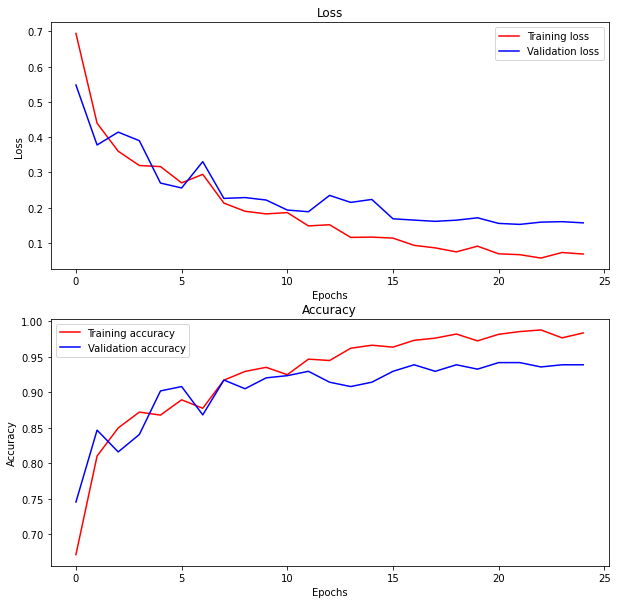

In [45]:
plot_history(history_1)

Actuals: [1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0
 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0
 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1]
Predictions: [1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0
 0 0 1 0 0 1 1 0 1

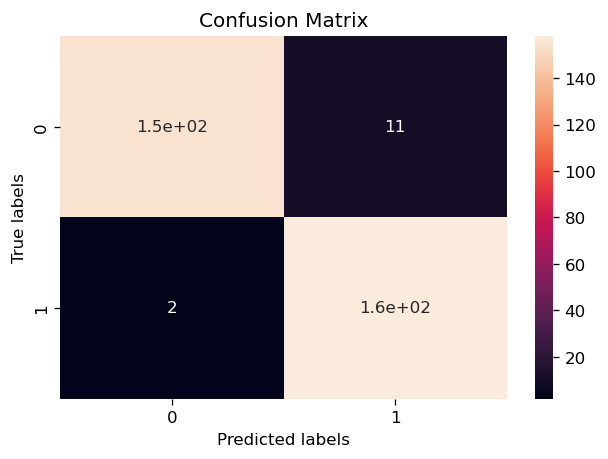

In [46]:
evaluation_1 = evalute_model(model_1, X_test, Y_test, batch_size=32)
confusion_matrix = evaluation_1[1]
accuracy = evaluation_1[0]
print("Test Accuracy: ", accuracy)
plot_confusion_matrix(confusion_matrix)



In [48]:
model_1.save('Save_model/model_1_96.h5')

VGG 16

In [17]:
model_2 = build_vgg16()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
history_2 = train_vgg16(model_2, train_light_generator,validation_light_generator, epochs=25)

Epoch 1/25
4/4 [==============================] - 11s 3s/step - loss: 0.9223 - accuracy: 0.4375 - val_loss: 1.2474 - val_accuracy: 0.7500
Epoch 2/25
4/4 [==============================] - 9s 2s/step - loss: 0.7384 - accuracy: 0.5625 - val_loss: 4.0193 - val_accuracy: 0.6250
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 0.7084 - accuracy: 0.5312 - val_loss: 4.4993 - val_accuracy: 0.6250
Epoch 4/25
4/4 [==============================] - 6s 1s/step - loss: 0.7518 - accuracy: 0.5000 - val_loss: 2.1643 - val_accuracy: 0.8750
Epoch 5/25
4/4 [==============================] - 7s 2s/step - loss: 0.7297 - accuracy: 0.6562 - val_loss: 4.4453 - val_accuracy: 0.5000
Epoch 6/25
4/4 [==============================] - 7s 2s/step - loss: 0.6705 - accuracy: 0.6875 - val_loss: 3.7960 - val_accuracy: 0.6250
Epoch 7/25
4/4 [==============================] - 8s 2s/step - loss: 0.6835 - accuracy: 0.6562 - val_loss: 1.0411 - val_accuracy: 1.0000
Epoch 8/25
4/4 [========================

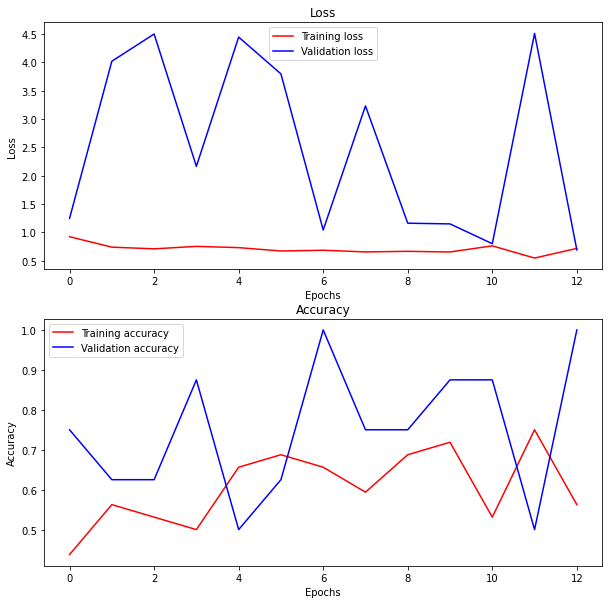

In [19]:
plot_history(history_2)

Actuals: [1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Predictions: [1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1]
[[8 7]
 [1 9]]
              precision    recall  f1-score   support

          no       0.89      0.53      0.67        15
         yes       0.56      0.90      0.69        10

    accuracy                           0.68        25
   macro avg       0.73      0.72      0.68        25
weighted avg       0.76      0.68      0.68        25

Accuracy: 0.680000
Test Accuracy:  0.68


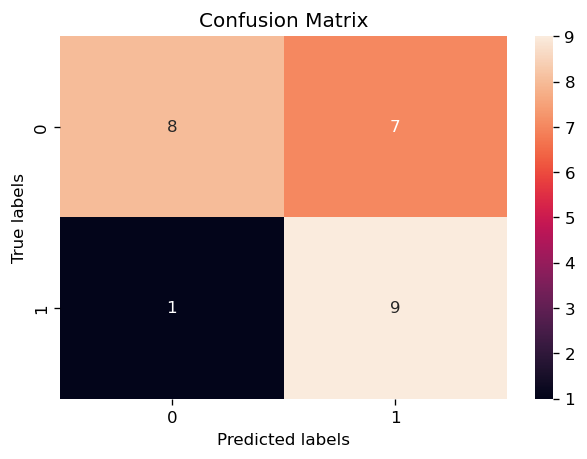

In [20]:
# Evaluate the model
evaluation_2 = evalute_model(model_2, X_light_test, Y_light_test, batch_size=5)
confusion_matrix_2 = evaluation_2[1]
accuracy_2 = evaluation_2[0]
print("Test Accuracy: ", accuracy_2)
plot_confusion_matrix(confusion_matrix_2)


RESNET

In [21]:
model_3 = build_resnet()

/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
history_3 = train_resnet(model_3, X_light_train, Y_light_train, X_light_val, Y_light_val, epochs=25)

Epoch 1/25
26/26 [==============================] - 17s 552ms/step - loss: 0.7375 - accuracy: 0.5545 - val_loss: 0.7209 - val_accuracy: 0.6923
Epoch 2/25
26/26 [==============================] - 12s 477ms/step - loss: 0.6155 - accuracy: 0.6485 - val_loss: 0.6940 - val_accuracy: 0.6923
Epoch 3/25
26/26 [==============================] - 17s 672ms/step - loss: 0.5676 - accuracy: 0.7277 - val_loss: 0.6717 - val_accuracy: 0.6923
Epoch 4/25
26/26 [==============================] - 15s 567ms/step - loss: 0.5240 - accuracy: 0.7871 - val_loss: 0.6601 - val_accuracy: 0.6923
Epoch 5/25
26/26 [==============================] - 15s 592ms/step - loss: 0.4981 - accuracy: 0.7822 - val_loss: 0.6490 - val_accuracy: 0.7308
Epoch 6/25
26/26 [==============================] - 14s 549ms/step - loss: 0.4678 - accuracy: 0.8465 - val_loss: 0.6385 - val_accuracy: 0.7308
Epoch 7/25
26/26 [==============================] - 15s 589ms/step - loss: 0.4431 - accuracy: 0.8614 - val_loss: 0.6335 - val_accuracy: 0.7308

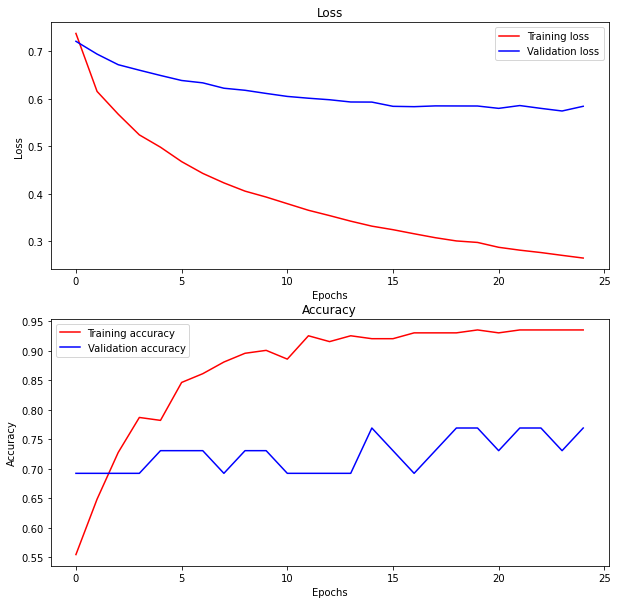

In [23]:
plot_history(history_3)

Actuals: [1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Predictions: [1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
[[13  2]
 [ 3  7]]
              precision    recall  f1-score   support

          no       0.81      0.87      0.84        15
         yes       0.78      0.70      0.74        10

    accuracy                           0.80        25
   macro avg       0.80      0.78      0.79        25
weighted avg       0.80      0.80      0.80        25

Accuracy: 0.800000
Test Accuracy:  0.8


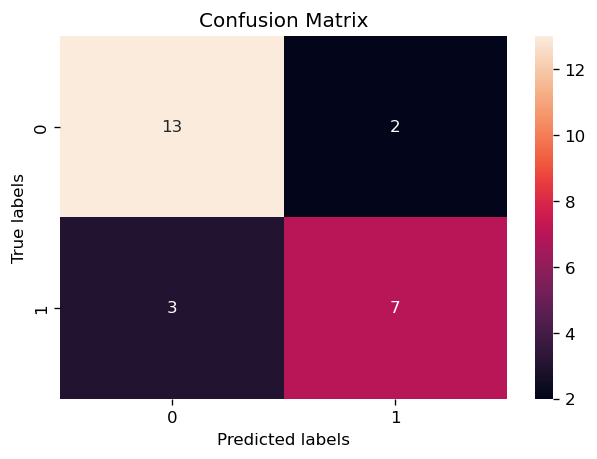

In [24]:
# Evaluate the model
evaluation_3= evalute_model(model_1, X_light_test, Y_light_test, batch_size=32)
confusion_matrix_3 = evaluation_3[1]
accuracy_3 = evaluation_3[0]
print("Test Accuracy: ", accuracy_3)
plot_confusion_matrix(confusion_matrix_3)
